# Predicting the number of international airline passengers
We will be doing this with a neural network. This is mainly for testing LSTM to see if its suitable for Foresight.

In [96]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import numpy as np

Import the necessary modules


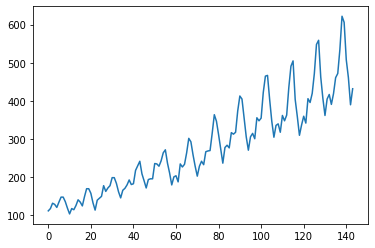

In [97]:
dataframe:pd.DataFrame = pd.read_csv('airline-passengers.csv', usecols=[1], engine='python')
plt.plot(dataframe)
plt.show()

Here we read the csv file containing the data as a dataframe, and we plot it.


We should first set a random seed

In [98]:
tf.random.set_seed(7)

Lets now change the *dataframe* from earlier to numpy integer values. Apparently this is better when working with neural networks.

In [99]:
dataset:np.ndarray = dataframe.values
dataset = dataset.astype('float32')
print(dataset)

[[112.]
 [118.]
 [132.]
 [129.]
 [121.]
 [135.]
 [148.]
 [148.]
 [136.]
 [119.]
 [104.]
 [118.]
 [115.]
 [126.]
 [141.]
 [135.]
 [125.]
 [149.]
 [170.]
 [170.]
 [158.]
 [133.]
 [114.]
 [140.]
 [145.]
 [150.]
 [178.]
 [163.]
 [172.]
 [178.]
 [199.]
 [199.]
 [184.]
 [162.]
 [146.]
 [166.]
 [171.]
 [180.]
 [193.]
 [181.]
 [183.]
 [218.]
 [230.]
 [242.]
 [209.]
 [191.]
 [172.]
 [194.]
 [196.]
 [196.]
 [236.]
 [235.]
 [229.]
 [243.]
 [264.]
 [272.]
 [237.]
 [211.]
 [180.]
 [201.]
 [204.]
 [188.]
 [235.]
 [227.]
 [234.]
 [264.]
 [302.]
 [293.]
 [259.]
 [229.]
 [203.]
 [229.]
 [242.]
 [233.]
 [267.]
 [269.]
 [270.]
 [315.]
 [364.]
 [347.]
 [312.]
 [274.]
 [237.]
 [278.]
 [284.]
 [277.]
 [317.]
 [313.]
 [318.]
 [374.]
 [413.]
 [405.]
 [355.]
 [306.]
 [271.]
 [306.]
 [315.]
 [301.]
 [356.]
 [348.]
 [355.]
 [422.]
 [465.]
 [467.]
 [404.]
 [347.]
 [305.]
 [336.]
 [340.]
 [318.]
 [362.]
 [348.]
 [363.]
 [435.]
 [491.]
 [505.]
 [404.]
 [359.]
 [310.]
 [337.]
 [360.]
 [342.]
 [406.]
 [396.]
 [420.]


We want to now scale these values down between 0 and 1 with a sigmoid or logistic function.


In [100]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

The airline problem is time based, meaning that the sequence of values is significant. Therefore, lets use the first 2 thirds of the data to train the model, and lets predict the last third, and compare it with the actual values.


In [101]:
trainingSize = int(len(dataset) * .667)
testingSize = len(dataset) - trainingSize
trainingValues = dataset[:trainingSize]
testingValues = dataset[trainingSize:]
print(f"Training size: {len(trainingValues)}\nTesting size:{len(testingValues)}")

Training size: 96
Testing size:48


Now we can define a function to create a new dataset, as described above.

The function takes two arguments: the dataset, which is a NumPy array that we want to convert into a dataset, and the look_back, which is the number of previous time steps to use as input variables to predict the next time period — in this case defaulted to 1.

This default will create a dataset where X is the number of passengers at a given time (t) and Y is the number of passengers at the next time (t + 1).

In [102]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

Lets use this function


In [103]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(trainingValues, look_back)
testX, testY = create_dataset(testingValues, look_back)
print(testX)

[[0.4073359 ]
 [0.3803089 ]
 [0.48648646]
 [0.47104248]
 [0.484556  ]
 [0.6138996 ]
 [0.6969112 ]
 [0.70077217]
 [0.57915056]
 [0.46911195]
 [0.38803086]
 [0.44787642]
 [0.45559844]
 [0.4131274 ]
 [0.4980695 ]
 [0.47104248]
 [0.49999997]
 [0.6389961 ]
 [0.7471043 ]
 [0.7741313 ]
 [0.57915056]
 [0.492278  ]
 [0.3976834 ]
 [0.44980696]
 [0.49420848]
 [0.45945945]
 [0.5830116 ]
 [0.5637065 ]
 [0.61003864]
 [0.71042466]
 [0.8571429 ]
 [0.8783784 ]
 [0.69305015]
 [0.5849421 ]
 [0.4980695 ]
 [0.58108103]
 [0.6042471 ]
 [0.554054  ]
 [0.60810804]
 [0.6891892 ]
 [0.71042466]
 [0.8320464 ]
 [1.        ]
 [0.96911204]
 [0.7799227 ]
 [0.6891892 ]]


The LSTM network expects the input data (X) to be provided with a specific array structure in the form of: [samples, time steps, features].

Currently, our data is in the form: [samples, features] and we are framing the problem as one time step for each sample. We can transform the prepared train and test input data into the expected structure using numpy.reshape() as follows:

In [104]:

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

We are now ready to design and fit our LSTM network for this problem.

The network has a visible layer with 1 input, a hidden layer with 4 LSTM blocks or neurons, and an output layer that makes a single value prediction. The default sigmoid activation function is used for the LSTM blocks. The network is trained for 100 epochs and a batch size of 1 is used.

In [105]:

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
94/94 - 1s - loss: 0.0431 - 1s/epoch - 13ms/step
Epoch 2/100
94/94 - 0s - loss: 0.0229 - 78ms/epoch - 828us/step
Epoch 3/100
94/94 - 0s - loss: 0.0163 - 79ms/epoch - 836us/step
Epoch 4/100
94/94 - 0s - loss: 0.0148 - 75ms/epoch - 802us/step
Epoch 5/100
94/94 - 0s - loss: 0.0140 - 81ms/epoch - 867us/step
Epoch 6/100
94/94 - 0s - loss: 0.0130 - 102ms/epoch - 1ms/step
Epoch 7/100
94/94 - 0s - loss: 0.0121 - 75ms/epoch - 796us/step
Epoch 8/100
94/94 - 0s - loss: 0.0112 - 77ms/epoch - 821us/step
Epoch 9/100
94/94 - 0s - loss: 0.0104 - 77ms/epoch - 821us/step
Epoch 10/100
94/94 - 0s - loss: 0.0094 - 75ms/epoch - 796us/step
Epoch 11/100
94/94 - 0s - loss: 0.0084 - 80ms/epoch - 855us/step
Epoch 12/100
94/94 - 0s - loss: 0.0074 - 99ms/epoch - 1ms/step
Epoch 13/100
94/94 - 0s - loss: 0.0066 - 104ms/epoch - 1ms/step
Epoch 14/100
94/94 - 0s - loss: 0.0057 - 101ms/epoch - 1ms/step
Epoch 15/100
94/94 - 0s - loss: 0.0050 - 102ms/epoch - 1ms/step
Epoch 16/100
94/94 - 0s - loss: 0.0043 - 88

Once the model is fit, we can estimate the performance of the model on the train and test datasets. This will give us a point of comparison for new models.

Note that we invert the predictions before calculating error scores to ensure that performance is reported in the same units as the original data (thousands of passengers per month).

In [106]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
print(trainPredict)

[[0.03273402]
 [0.04303372]
 [0.06737775]
 [0.06212618]
 [0.04821448]
 [0.07264751]
 [0.09568042]
 [0.09568042]
 [0.07440804]
 [0.0447584 ]
 [0.01913489]
 [0.04303372]
 [0.03787341]
 [0.05689323]
 [0.08323942]
 [0.07264751]
 [0.05515317]
 [0.0974647 ]
 [0.13529606]
 [0.13529606]
 [0.11359721]
 [0.06913236]
 [0.03615793]
 [0.08146936]
 [0.0903379 ]
 [0.09925069]
 [0.14986652]
 [0.1226138 ]
 [0.1389314 ]
 [0.14986652]
 [0.18842936]
 [0.18842936]
 [0.16084209]
 [0.12080759]
 [0.09211701]
 [0.12804091]
 [0.1371131 ]
 [0.15352076]
 [0.1773717 ]
 [0.15534952]
 [0.1590102 ]
 [0.22359216]
 [0.2458704 ]
 [0.26816344]
 [0.20691296]
 [0.17369217]
 [0.1389314 ]
 [0.17921269]
 [0.18289706]
 [0.18289706]
 [0.25701714]
 [0.25515926]
 [0.24401288]
 [0.27002087]
 [0.30896685]
 [0.32375315]
 [0.25887498]
 [0.21061641]
 [0.15352076]
 [0.19212109]
 [0.19766358]
 [0.1681794 ]
 [0.25515926]
 [0.24029818]
 [0.25330138]
 [0.30896685]
 [0.37877005]
 [0.3623508 ]
 [0.29970834]
 [0.24401288]
 [0.19581547]
 [0.24

In [107]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))


allVals = np.concatenate((trainPredict, testPredict), axis=0)
print(len(allVals))
print(len(testPredict))
print(len(trainPredict))

Train Score: 22.68 RMSE
Test Score: 49.34 RMSE
140
46
94


Finally, we can generate predictions using the model for both the train and test dataset to get a visual indication of the skill of the model.

Because of how the dataset was prepared, we must shift the predictions so that they align on the x-axis with the original dataset. Once prepared, the data is plotted, showing the original dataset in blue, the predictions for the training dataset in orange, and the predictions on the unseen test dataset in green.

(144, 1)
(46, 1)


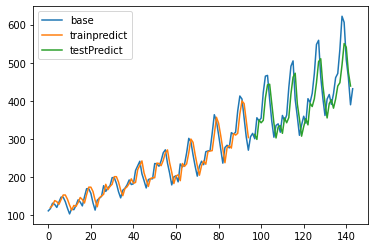

In [108]:

# shift train predictions for plotting
print(dataset.shape)
trainPredictPlot = np.empty(shape=(19000, 1))
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
print(testPredict.shape)
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset), label="base")
plt.plot(trainPredictPlot, label="trainpredict")
plt.plot(testPredictPlot, label="testPredict")
# plt.plot(allVals, label="allVals")
plt.legend()
plt.show()

In [109]:

print(trainPredict)

[[120.95622 ]
 [126.291466]
 [138.90167 ]
 [136.18137 ]
 [128.9751  ]
 [141.63141 ]
 [153.56245 ]
 [153.56245 ]
 [142.54335 ]
 [127.184845]
 [113.91187 ]
 [126.291466]
 [123.61843 ]
 [133.47069 ]
 [147.11801 ]
 [141.63141 ]
 [132.56934 ]
 [154.48672 ]
 [174.08337 ]
 [174.08337 ]
 [162.84335 ]
 [139.81056 ]
 [122.72981 ]
 [146.20113 ]
 [150.79503 ]
 [155.41187 ]
 [181.63086 ]
 [167.51396 ]
 [175.96646 ]
 [181.63086 ]
 [201.60641 ]
 [201.60641 ]
 [187.31621 ]
 [166.57834 ]
 [151.71661 ]
 [170.3252  ]
 [175.02458 ]
 [183.52376 ]
 [195.87854 ]
 [184.47105 ]
 [186.36728 ]
 [219.82074 ]
 [231.36086 ]
 [242.90866 ]
 [211.18092 ]
 [193.97255 ]
 [175.96646 ]
 [196.83217 ]
 [198.74068 ]
 [198.74068 ]
 [237.13487 ]
 [236.1725  ]
 [230.39867 ]
 [243.87082 ]
 [264.04483 ]
 [271.70413 ]
 [238.09724 ]
 [213.0993  ]
 [183.52376 ]
 [203.51872 ]
 [206.38974 ]
 [191.11693 ]
 [236.1725  ]
 [228.47446 ]
 [235.21011 ]
 [264.04483 ]
 [300.2029  ]
 [291.69772 ]
 [259.24893 ]
 [230.39867 ]
 [205.43242 ]
 [230.